In [3]:
import kagglehub
ananthu017_emotion_detection_fer_path = kagglehub.dataset_download('ananthu017/emotion-detection-fer')
print(ananthu017_emotion_detection_fer_path)

C:\Users\Pranav\.cache\kagglehub\datasets\ananthu017\emotion-detection-fer\versions\1


In [1]:
# ----------------------------------------
# 1. Importing Libraries and Modules
# ----------------------------------------

import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

print('modules loaded')

modules loaded


In [8]:
# ----------------------------------------
# 2. Load the Full Dataset (Training Data)
# ----------------------------------------

train_dir = ananthu017_emotion_detection_fer_path + '\\train'
print("Train Directory:", train_dir)
train_filepaths = []
train_labels = []

# Loop over each folder corresponding to an emotion in the train directory
folds = os.listdir(train_dir)
for fold in folds:
    fold_path = os.path.join(train_dir, fold)
    filelist = os.listdir(fold_path)
    for file in filelist:
        fpath = os.path.join(fold_path, file)
        train_filepaths.append(fpath)
        train_labels.append(fold)

# Concatenate file paths and labels into a dataframe
Fseries = pd.Series(train_filepaths, name='filepaths')
Lseries = pd.Series(train_labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis=1)

print("Full Training DataFrame shape:", train_df.shape)


Train Directory: C:\Users\Pranav\.cache\kagglehub\datasets\ananthu017\emotion-detection-fer\versions\1\train
Full Training DataFrame shape: (28709, 2)


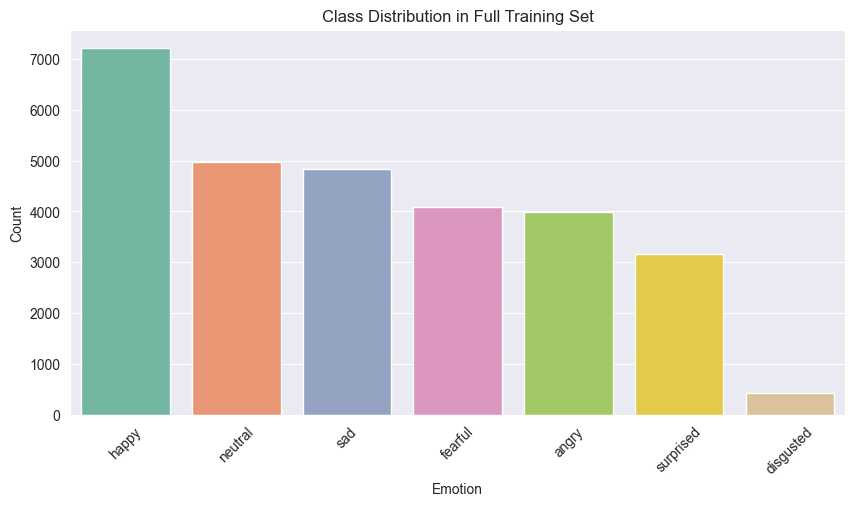

In [ ]:
# ----------------------------------------
# 3. Plot the Distribution of All Classes from the Full Dataset
# ----------------------------------------

plt.figure(figsize=(10, 5))
sns.countplot(data=train_df, x='labels', order=train_df['labels'].value_counts().index, palette='Set2')
plt.title('Class Distribution in Full Training Set')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# ----------------------------------------
# 4. Create a Balanced Subset of the Training Data
# ----------------------------------------



Class Counts:
labels
happy        7215
neutral      4965
sad          4830
fearful      4097
angry        3995
surprised    3171
disgusted     436
Name: count, dtype: int64

Number of 'sad' samples = 4830



Class Counts:
labels
happy        7215
neutral      4965
sad          4830
fearful      4097
angry        3995
surprised    3171
disgusted     436
Name: count, dtype: int64

Number of 'sad' samples = 4830

Augmenting class 'angry' to match 4830 samples...

Augmenting class 'disgusted' to match 4830 samples...

Augmenting class 'fearful' to match 4830 samples...

Augmenting class 'surprised' to match 4830 samples...

New training DataFrame shape (after augmentation): (36330, 2)

Final Class Counts After Augmentation:
labels
happy        7215
neutral      4965
angry        4830
disgusted    4830
fearful      4830
sad          4830
surprised    4830
Name: count, dtype: int64


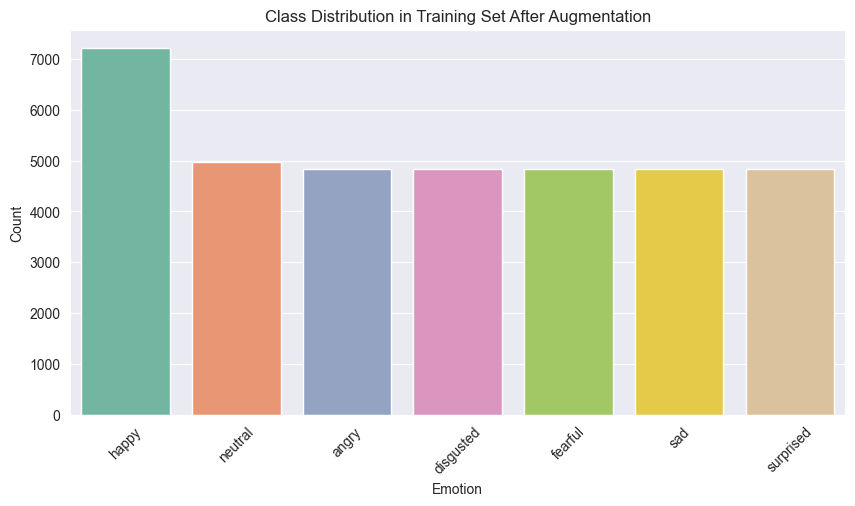

In [13]:

import os
import time
import uuid
import shutil
import pathlib
import itertools
from PIL import Image

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# ----------------------------------------
# 3. Get Count of "sad" Class
# ----------------------------------------
print("\nClass Counts:")
print(train_df['labels'].value_counts())

sadcnt = train_df['labels'].value_counts()['sad']
print(f"\nNumber of 'sad' samples = {sadcnt}")

# ----------------------------------------
# 4. Define a Function to Augment Images
# ----------------------------------------
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def augment_images(image_paths, augment_count, output_dir, class_name, target_size=(48, 48)):
    """
    Augment images until 'augment_count' new samples have been generated.
    
    Params:
    -------
    image_paths : list of str
        Paths to original images of a given class.
    augment_count : int
        Number of new images to generate.
    output_dir : str
        Directory where augmented images will be saved.
    class_name : str
        The label/class name for which we are generating augmented samples.
    target_size : tuple
        (height, width) to which each image is resized if desired.
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # Define your data augmentation pipeline
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Lists to keep track of newly generated samples
    augmented_filepaths = []
    augmented_labels = []

    images_created = 0

    # We'll loop until we've created the required augment_count
    while images_created < augment_count:
        for img_path in image_paths:
            if images_created >= augment_count:
                break
            
            # Read and prepare the image
            img = cv2.imread(img_path)
            if img is None:
                # If there's an issue reading an image, skip it
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # (Optional) Resize the image if needed
            if target_size is not None:
                img = cv2.resize(img, target_size)
            
            # Expand dims so that it has shape (1, height, width, channels)
            x = np.expand_dims(img, axis=0)

            # Generate one augmented image
            for batch_out in datagen.flow(x, batch_size=1):
                augmented_img = batch_out[0].astype('uint8')
                
                # Convert back to BGR for OpenCV to save
                augmented_img_bgr = cv2.cvtColor(augmented_img, cv2.COLOR_RGB2BGR)
                
                # Create a unique file name
                file_name = f"{class_name}_{uuid.uuid4()}.jpg"
                file_path = os.path.join(output_dir, file_name)
                
                # Write augmented image to disk
                cv2.imwrite(file_path, augmented_img_bgr)
                
                # Store the new file path and label
                augmented_filepaths.append(file_path)
                augmented_labels.append(class_name)
                
                images_created += 1
                # Break so we only produce 1 augmented image per iteration of datagen.flow
                break

    # Return newly generated file paths and labels
    return augmented_filepaths, augmented_labels

# ----------------------------------------
# 5. Augment Classes that Have Fewer Samples than "sad"
# ----------------------------------------

augmented_filepaths_all = []
augmented_labels_all = []

# For each class, if its count < sadcnt, augment
for cls in train_df['labels'].unique():
    cls_count = (train_df['labels'] == cls).sum()
    if cls_count < sadcnt:
        needed = sadcnt - cls_count
        print(f"\nAugmenting class '{cls}' to match {sadcnt} samples...")
        # Collect all the filepaths for this class
        cls_paths = train_df.loc[train_df['labels'] == cls, 'filepaths'].tolist()
        
        # Output directory for augmented images of this class
        out_dir = f"/kaggle/working/augmented_data/{cls}"
        
        # Generate 'needed' new images
        new_paths, new_labels = augment_images(
            image_paths=cls_paths,
            augment_count=needed,
            output_dir=out_dir,
            class_name=cls,
            target_size=(48, 48)  # Adjust to your model's required input size
        )
        
        # Accumulate results
        augmented_filepaths_all.extend(new_paths)
        augmented_labels_all.extend(new_labels)

# Create a small DataFrame of the newly augmented data
aug_df = pd.DataFrame({
    'filepaths': augmented_filepaths_all,
    'labels': augmented_labels_all
})

# ----------------------------------------
# 6. Combine Augmented Data with Original train_df
# ----------------------------------------
train_df_aug = pd.concat([train_df, aug_df], axis=0).reset_index(drop=True)

print("\nNew training DataFrame shape (after augmentation):", train_df_aug.shape)

# Verify final counts
final_counts = train_df_aug['labels'].value_counts()
print("\nFinal Class Counts After Augmentation:")
print(final_counts)

# Plot the new distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=train_df_aug, x='labels', order=final_counts.index, palette='Set2')
plt.title('Class Distribution in Training Set After Augmentation')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Found 29064 validated image filenames belonging to 7 classes.
Found 7266 validated image filenames belonging to 7 classes.


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 46, 46, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 16928)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │     1,083,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,084,807 (4.14 MB)

 Trainable params: 1,084,807 (4.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
909/909 ━━━━━━━━━━━━━━━━━━━━ 589s 646ms/step - accuracy: 0.3054 - loss: 1.7794 - val_accuracy: 0.4111 - val_loss: 1.5673
Epoch 2/20
909/909 ━━━━━━━━━━━━━━━━━━━━ 84s 92ms/step - accuracy: 0.4455 - loss: 1.5012 - val_accuracy: 0.4353 - val_loss: 1.5130
Epoch 3/20
909/909 ━━━━━━━━━━━━━━━━━━━━ 88s 97ms/step - accuracy: 0.5009 - loss: 1.3562 - val_accuracy: 0.4568 - val_loss: 1.4723
Epoch 4/20
909/909 ━━━━━━━━━━━━━━━━━━━━ 83s 91ms/step - accuracy: 0.5506 - loss: 1.2374 - val_accuracy: 0.4633 - val_loss: 1.4724
Epoch 5/20
909/909 ━━━━━━━━━━━━━━━━━━━━ 84s 93ms/step - accuracy: 0.5936 - loss: 1.1243 - val_accuracy: 0.4576 - val_loss: 1.5033
Epoch 6/20
909/909 ━━━━━━━━━━━━━━━━━━━━ 83s 92ms/step - accuracy: 0.6311 - loss: 1.0219 - val_accuracy: 0.4653 - val_loss: 1.5572
Epoch 7/20
909/909 ━━━━━━━━━━━━━━━━━━━━ 67s 74ms/step - accuracy: 0.6702 - loss: 0.9221 - val_accuracy: 0.4703 - val_loss: 1.5886
Epoch 8/20
909/909 ━━━━━━━━━━━━━━━━━━━━ 80s 87ms/step - accuracy: 0.7194 - loss: 0.8007 

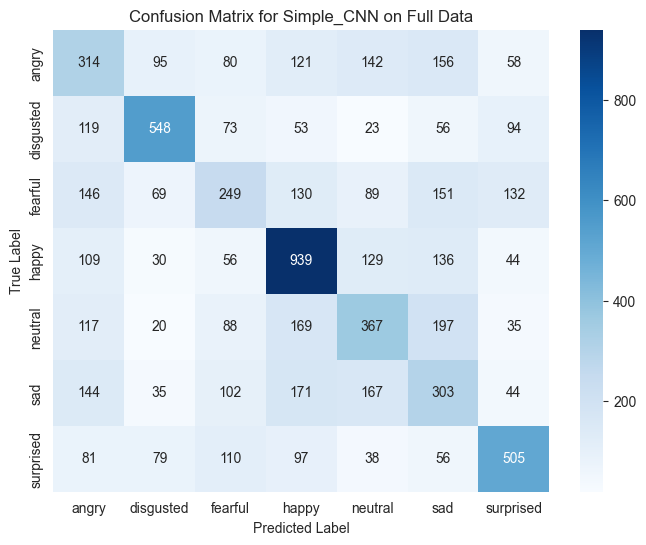

In [15]:
# ----------------------------------------
# 10. Retrain the Best Model (Simple_CNN) on the Entire Augmented Dataset
# ----------------------------------------

# For reproducibility
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Parameters for full training
BATCH_SIZE_FULL = 32
IMG_SIZE = (48, 48)
EPOCHS_FULL = 20  # Increase the number of epochs for full training
NUM_CLASSES = len(train_df_aug['labels'].unique())

# Split the entire augmented dataframe into a training set and a validation set (80/20 split)
full_train_df, full_val_df = train_test_split(
    train_df_aug, 
    test_size=0.2, 
    random_state=42, 
    stratify=train_df_aug['labels']
)

# Create data generators (images are rescaled to [0,1])
train_datagen_full = ImageDataGenerator(rescale=1./255)
val_datagen_full = ImageDataGenerator(rescale=1./255)

train_generator_full = train_datagen_full.flow_from_dataframe(
    dataframe=full_train_df,
    x_col="filepaths",
    y_col="labels",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE_FULL,
    shuffle=True
)

validation_generator_full = val_datagen_full.flow_from_dataframe(
    dataframe=full_val_df,
    x_col="filepaths",
    y_col="labels",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE_FULL,
    shuffle=False
)

# Re-define the best performing model: Simple_CNN
def create_model_simple():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

best_model = create_model_simple()
best_model.summary()

# Train the best model on the full augmented data
history_full = best_model.fit(
    train_generator_full,
    epochs=EPOCHS_FULL,
    validation_data=validation_generator_full,
    verbose=1
)

# Evaluate the retrained model on the full validation set
val_loss_full, val_acc_full = best_model.evaluate(validation_generator_full, verbose=0)
print(f"\nSimple_CNN on full data - Validation Accuracy: {val_acc_full*100:.2f}% and Loss: {val_loss_full:.4f}")

# Generate predictions to display a detailed classification report and confusion matrix
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Get predicted classes
Y_pred_full = best_model.predict(validation_generator_full)
y_pred_full = np.argmax(Y_pred_full, axis=1)
y_true_full = validation_generator_full.classes
class_labels_full = list(validation_generator_full.class_indices.keys())

print("\nClassification Report for Simple_CNN on Full Data:")
print(classification_report(y_true_full, y_pred_full, target_names=class_labels_full))

# Plot and display the confusion matrix
cm_full = confusion_matrix(y_true_full, y_pred_full)
plt.figure(figsize=(8,6))
sns.heatmap(cm_full, annot=True, fmt="d", xticklabels=class_labels_full, yticklabels=class_labels_full, cmap="Blues")
plt.title("Confusion Matrix for Simple_CNN on Full Data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [20]:
best_model.save('best_model_full.h5')